# Texture Transfer Using Estimated Dense Coordinates

# 使用估计的密集坐标进行纹理传输

本文档演示如何使用估计的密集坐标将纹理从UV空间映射到图像像素。  
为此，我们提供了一个“图集”纹理空间，可以轻松设计自定义纹理。我们还提供了一种从[SURREAL数据集](https://www.di.ens.fr/willow/research/surreal/data/)获得的修改后的纹理，它允许复制我们在论文中提供的定性结果。

让我们首先用示例纹理可视化UV图集空间：

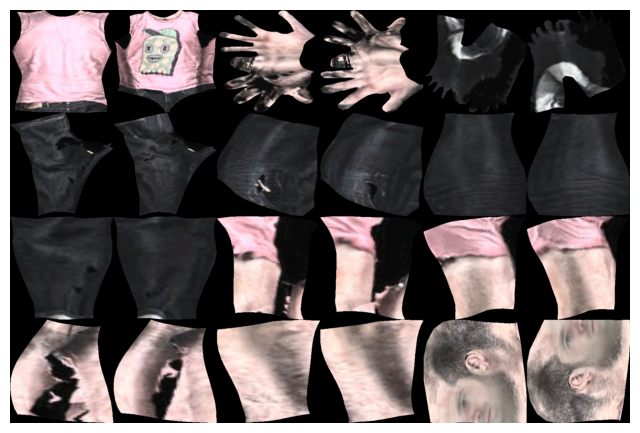

In [1]:
import numpy
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 原始人体纹理，共24个部分，每一部分纹理图像为200*200，颜色为RGB三维
fig = plt.figure(figsize=[8,8])

import os
# 如果路径不对，将DensePoseData_dir改为你的绝对路径
# DensePoseData_dir = "D:\\projects\\DensePose\\DensePoseData"
DensePoseData_dir = os.path.abspath("../DensePoseData")
Tex_Atlas = cv2.imread(os.path.join(DensePoseData_dir, 'demo_data/texture_from_SURREAL.png'))[:,:,::-1]/255.
plt.imshow(Tex_Atlas.transpose([1,0,2]));plt.axis('off'); plt.show()
# 
TextureIm  = np.zeros([24,200,200,3]);
# 将“图集”表示的人体纹理，按照24个部分分割
for i in range(4):
    for j in range(6):
        TextureIm[(6*i+j) , :,:,:] = Tex_Atlas[ (200*j):(200*j+200)  , (200*i):(200*i+200) ,: ]

上述纹理来自[SURREAL数据集](https://www.di.ens.fr/willow/research/surreal/data/)中提供的纹理。

人们基本上可以在提供的纹理图像上设计自己的纹理。我们提供白色表面和黑色边缘作为纹理图谱指南，如下图所示。

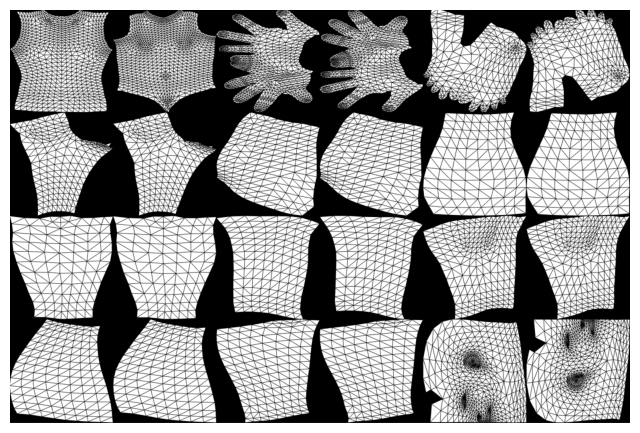

In [2]:
# 可视化2D纹理对应的3D曲面展开图
fig = plt.figure(figsize=[8,8])
Tex_Atlas = cv2.imread(os.path.join(DensePoseData_dir, 'demo_data/texture_atlas_200.png'))[:,:,::-1]
plt.imshow(Tex_Atlas.transpose([1,0,2]));plt.axis('off'); plt.show()

在这里，我们定义了将纹理转移到图像域的函数。

In [3]:
# 2D纹理“图集”--（映射）->3D模型--（渲染）-->2D图像
# IUV隐含了中间步骤。从纹理图像渲染到2D图像上
def TransferTexture(TextureIm,im,IUV):
    U = IUV[:,:,1]
    V = IUV[:,:,2]
    #
    R_im = np.zeros(U.shape)
    G_im = np.zeros(U.shape)
    B_im = np.zeros(U.shape)
    ###
    # 对于每个人体部分（共24个）
    for PartInd in range(1,25):    ## Set to range(1,23) to ignore the face part.
        tex = TextureIm[PartInd-1,:,:,:].squeeze() # get texture for each part.
        #####
        R = tex[:,:,0]
        G = tex[:,:,1]
        B = tex[:,:,2]
        ###############
        # 筛选I值为当前部分的关键点，并其得到在该部分内的U、V坐标
        x,y = np.where(IUV[:,:,0]==PartInd)
        u_current_points = U[x,y]   #  Pixels that belong to this specific part.
        v_current_points = V[x,y]
        ##
        # 该部分内的关键点颜色，索引从0-k，[i, R/G/B]
        r_current_points = R[((255-v_current_points)*199./255.).astype(int),(u_current_points*199./255.).astype(int)]*255
        g_current_points = G[((255-v_current_points)*199./255.).astype(int),(u_current_points*199./255.).astype(int)]*255
        b_current_points = B[((255-v_current_points)*199./255.).astype(int),(u_current_points*199./255.).astype(int)]*255
        ##  Get the RGB values from the texture images.
        # 2D图像内关键点的颜色，[x, y, R/G/B]
        R_im[IUV[:,:,0]==PartInd] = r_current_points
        G_im[IUV[:,:,0]==PartInd] = g_current_points
        B_im[IUV[:,:,0]==PartInd] = b_current_points
    # 拼接人体图像，并替换背景为原始背景
    generated_image = np.concatenate((B_im[:,:,np.newaxis],G_im[:,:,np.newaxis],R_im[:,:,np.newaxis]), axis =2 ).astype(np.uint8)
    BG_MASK = generated_image==0
    generated_image[BG_MASK] = im[BG_MASK]  ## Set the BG as the old image.
    return generated_image

读取通过渲染SMPL模型获得的IUV文件并传输纹理

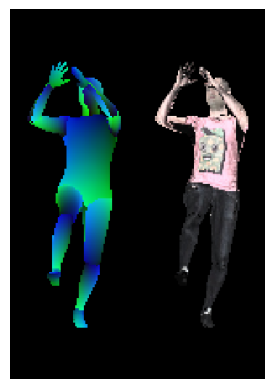

In [4]:
# IUV：在imshow中Red=I、Green=U、Blue=V；由于I的范围仅为低25个，在可视化后红色较少，可以通过归一化/24*255来调整
# image：纹理映射后的图像
IUV = cv2.imread(os.path.join(DensePoseData_dir, 'demo_data/synth_UV_example.png'))
im  = np.zeros(IUV.shape)
##
image = TransferTexture(TextureIm,im,IUV)
##
plt.imshow( np.hstack((IUV,image[:,:,::-1]))); plt.axis('off'); plt.show()

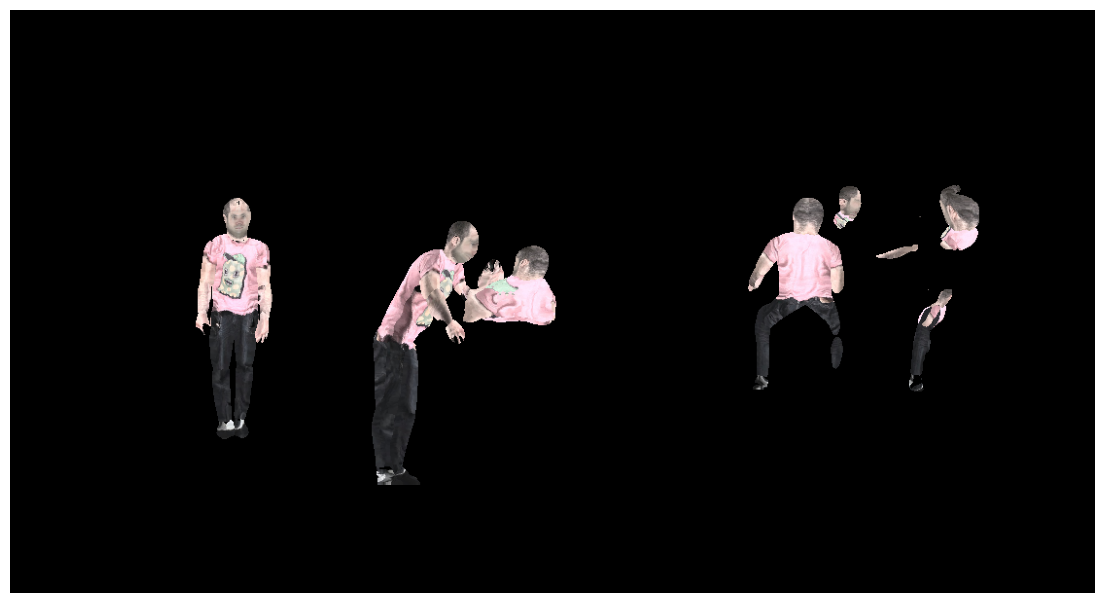

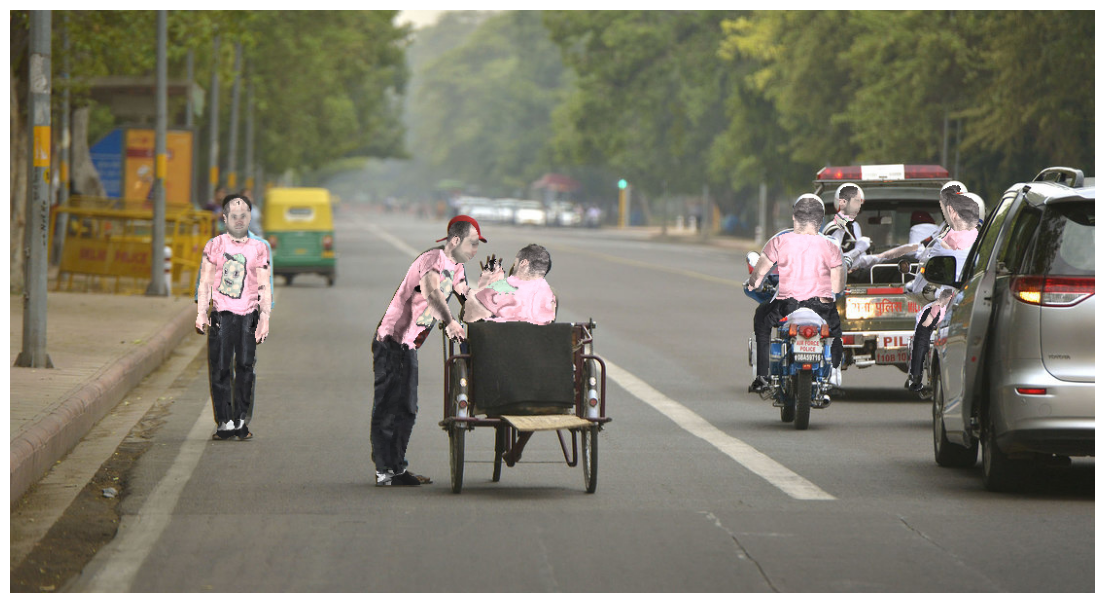

In [5]:
# IUV纹理图像、im原始图像，image纹理映射后的图像
IUV = cv2.imread(os.path.join(DensePoseData_dir, 'infer_out/demo_im_IUV.png'))
im  = cv2.imread(os.path.join(DensePoseData_dir, 'demo_data/demo_im.jpg'))
#######
## Visualize the image with black background，黑色背景
image = TransferTexture(TextureIm,np.zeros(IUV.shape),IUV)
fig = plt.figure(figsize=[14,14])
plt.imshow(image[:,:,::-1]); plt.axis('off'); plt.show()
#######
## Visualize the image with the image as the background，原始背景
image = TransferTexture(TextureIm,im,IUV)
fig = plt.figure(figsize=[14,14])
plt.imshow(image[:,:,::-1]); plt.axis('off'); plt.show()

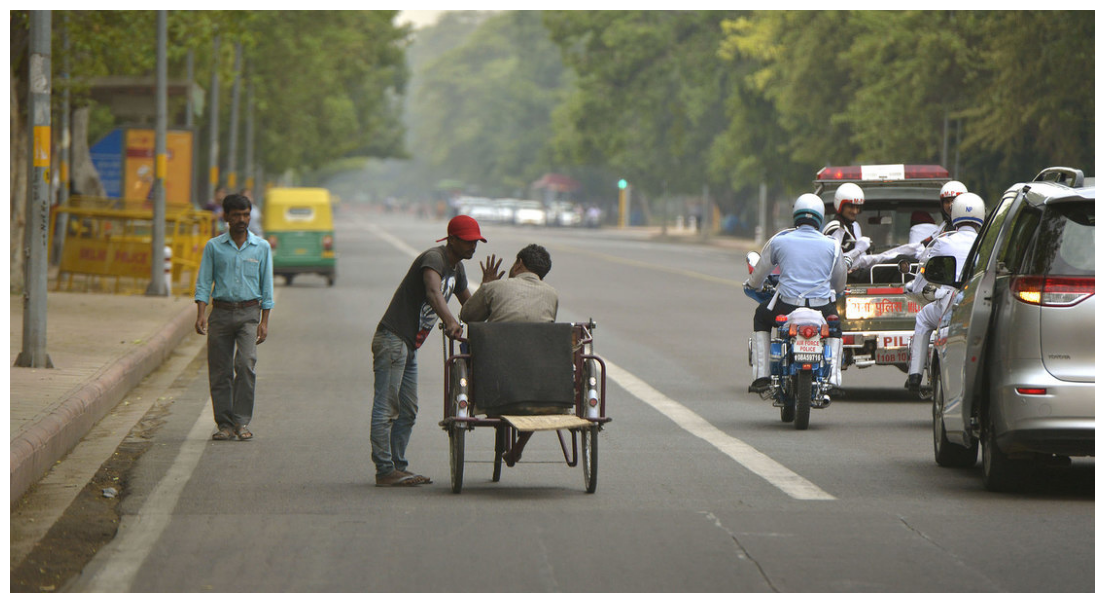

In [6]:
# 原始图像
im  = cv2.imread(os.path.join(DensePoseData_dir, 'demo_data/demo_im.jpg'))
plt.figure(figsize= [14,14])
plt.imshow(im[:,:,::-1]); plt.axis('off');plt.show()